# **Diffusion models from scratch, from a new theoretical perspective**

**Diffusion models trained by:**

1. Sampling $x_0 \sim K$ noise level $\sigma \sim [\sigma_{min},\sigma_{max}]$, noise $\epsilon \sim N(0, I)$
2. Generating noisy data $x_{\sigma} = x_0 + \sigma \epsilon$
3. Prediction $\epsilon$ (direction of noise) from $x_{\sigma}$ by minimizing squared loss

In [18]:
import math
from itertools import pairwise

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


In [7]:
class Schedule():
    def __init__(self, sigmas: torch.FloatTensor):
        self.sigmas = sigmas

    def __getitem__(self, i) -> torch.FloatTensor:
        return self.sigmas[i]
    
    def __len__(self) -> int:
        return len(self.sigmas)
    
    def sample_batch(self, x0: torch.FloatTensor) -> torch.FloatTensor:
        return self[torch.randint(len(self), (x0.shape[0],))].to(x0)

In [9]:
class ScheduleLogLinear(Schedule):
    def __init__(self,
                 N: int,
                 sigma_min: float = 0.02,
                 sigma_max: float = 10):
        
        super().__init__(torch.logspace(
            math.log10(sigma_max, N)
        ))

In [6]:
def generate_train_sample(
                        x0: torch.FloatTensor,
                        schedule: Schedule):
    sigma = schedule.sample_batch(x0)
    eps = torch.randn_like(x0)
    return sigma, eps

In [5]:
def training_loop(
                loader: DataLoader,
                model: nn.Module,
                schedule: Schedule,
                epochs: int = 10000):
    
    optimizer = torch.optim.Adam(model.parameters())
    for _ in range(epochs):
        for x0 in loader:
            optimizer.zero_grad()
            sigma, eps = generate_train_sample(x0, schedule)
            eps_hat = model(x0 + sigma * eps, sigma)
            loss = nn.MSELoss()(eps_hat, eps)
            optimizer.backward(loss)
            optimizer.step()



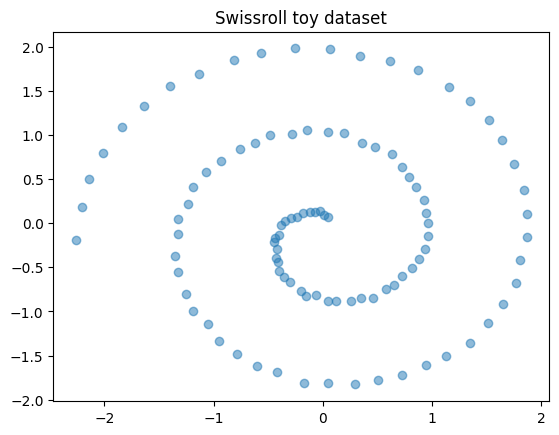

In [16]:
def swissroll(n_samples=1000, start=np.pi/2, stop=5*np.pi, noise=0.1):
    """Generates a 2D Swiss Roll (spiral)."""
    t = np.linspace(start, stop, n_samples)
    x = t * np.cos(t)
    y = t * np.sin(t)
    X = np.column_stack((x, y))
    X += noise * np.random.randn(*X.shape)  # Add noise
    return X

# Generate data
X = swissroll(n_samples=100, start=np.pi/2, stop=5*np.pi)

# Normalize (optional but recommended)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Convert to PyTorch Dataset
dataset = TensorDataset(torch.from_numpy(X).float())
loader = DataLoader(dataset, batch_size=2048, shuffle=True)

# Visualize
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.title('Swissroll toy dataset')
plt.show()

For this simple dataset, we can implement the denoiser using a `multi-layer perceptron` (MLP)

In [17]:
def get_sigma_embeds(sigma):
    sigma = sigma.unsqueeze(1)
    return torch.cat([
        torch.sin(torch.log(sigma)/2),
        torch.cos(torch.log(sigma)/2)
        ])

In [ ]:
class TimeInputMLP(nn.Module):
    def __init__(self, dim, hidden_dims):
        super().__init__()
        layers = []

        # for in_dim, out_dim in pairwise(())